# Duration of last scan, trajectory, and total number of scans

This combines previous figs from notebooks: `fig_last_scan_AR1.3.ipynb` and `fig_combine_scan.ipynb`.

In [1]:
from pathlib import Path

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

In [2]:
from pp_utils.core import generate_data_path_dict, MISC_PARAMS
from pp_utils.file_handling import df_main_loader
from pp_utils.trial_processor import TrialProcessor
from pp_utils import utils, utils_plot

In [3]:
import pickle

## Set paths, load main info df and clusters

In [4]:
data_path = generate_data_path_dict(Path("../data_processed/"))
raw_path = Path("../data_raw/")

### Data and output path

In [5]:
output_path = data_path["main"] / "data_summary"
tp_path = output_path / "trial_processor_object"

In [6]:
fig_path = Path("../figs")
if not fig_path.exists():
    fig_path.mkdir()

In [7]:
stat_path = Path("../stat")

### Load main dataframe

In [8]:
df_main = df_main_loader(
    folder=data_path["info_csv"], filename="main_info_append_09.csv",
)

### Load clustering results

In [9]:
with open(output_path / "clustering_7_rostrum_only.pickle", "rb") as filein:
    cluster_fnameprefix_7 = pickle.load(filein)

### Load compiled trial info

In [10]:
df_summary = pd.read_csv(output_path / "data_summary_all.csv", index_col=0)

In [11]:
df_summary["TRIAL_TO_INCLUDE"] = df_main["TRIAL_TO_INCLUDE"]

In [12]:
df_summary["TCCT"] = df_main["LEFT"] + df_main["RIGHT"]

## Spheroid names and colors

In [13]:
SPH_COLORS = ["w", "gainsboro", "darkgrey"]  # L, M, S

In [14]:
SPH_STR = ["L", "M", "S"]
SPH_LABEL = ["2.9", "1.3", "1.1"] # ["AR=2.9", "AR=1.3", "AR=1.1"]

In [15]:
sph_tcct = [f"{sph}_{tcct_type}" for sph, tcct_type in zip(["L", "M", "S"]*2, ["TC"]*3+["CT"]*3)]

In [16]:
sph_tcct

['L_TC', 'M_TC', 'S_TC', 'L_CT', 'M_CT', 'S_CT']

## Sort clusters

### 7clusters

In [17]:
# Clean up clusters
# 0: TC-straight, 1: TC-very curved, 2: TC-curved (need to change sequence to: 0-2-1)
# 3: CT-very curved, 4: CT-curved, 6: CT-straight (need to change sequence to: 6-4-3)
df_cluster_7 = []
for seq, fp_list in enumerate(cluster_fnameprefix_7):
    df_sel = utils.sort_df_in_cluster(fp_list, df_summary)
    df_cluster_7.append(df_sel)

In [18]:
# Change sequence
new_seq = [0, 2, 1, 6, 4, 3]
df_cluster_clean_7 = []
for seq in new_seq:
    df_cluster_clean_7.append(df_cluster_7[seq])

In [19]:
# Sanity check that we've swapped things correctly
print([len(df) for df in df_cluster_7])
print([len(df) for df in df_cluster_clean_7])

[16, 9, 16, 6, 8, 1, 23]
[16, 16, 9, 23, 8, 6]


## Cluster names and colors

### M spheroid - 7 clusters

In [20]:
color_cluster_7 = {
    "TC_straight": "#0077BB",  #"#004488"
    "TC_curved1": "black",
    "TC_curved2": "#EE6677",  #"#BB5566"
    "CT_straight": "#762A83",  # purple
    "CT_curved1": "black",
    "CT_curved2": "#1B7837",  # green
}
color_cluster_seq_7 = list(color_cluster_7.values())

In [21]:
CLUSTER_STR_7 = ["Straight", "Curved-1", "Curved-2", "Straight", "Curved-1", "Curved-2"]

## Track during last scan

In [22]:
def get_last_scan_track(trial_idx):
    
    # Load TrialProcessor object
    tp_obj_fname = tp_path / f"trial_{trial_idx:03d}.pickle"
    with open(tp_obj_fname, "rb") as filein:
        tp = pickle.load(filein)
       
    # Get track and track portion
    df_track = tp.df_track
    df_track_last_scan = df_track[
        (df_track["time_corrected"] > tp.last_scan_start)
        & (df_track["time_corrected"] < tp.last_scan_end)
    ].copy()

    return df_track, df_track_last_scan

In [23]:
# Gather all tracks
df_track_all = []
df_track_ls_all = []

for c_seq, df_c in enumerate(df_cluster_clean_7):  # loop through all clusters
    
    print(f"Extracting tracks from cluster {c_seq}")
    print(f"Number of tracks: {len(df_c)}")
    
    # Loop through all trials
    df_track_tmp = []
    df_track_ls_tmp = []
    for trial_idx in df_c.index:
        df_track, df_track_ls = get_last_scan_track(trial_idx)

        df_track_tmp.append(df_track)
        df_track_ls_tmp.append(df_track_ls)
    
    df_track_all.append(df_track_tmp)
    df_track_ls_all.append(df_track_ls_tmp)

Extracting tracks from cluster 0
Number of tracks: 16
Extracting tracks from cluster 1
Number of tracks: 16
Extracting tracks from cluster 2
Number of tracks: 9
Extracting tracks from cluster 3
Number of tracks: 23


Extracting tracks from cluster 4
Number of tracks: 8
Extracting tracks from cluster 5
Number of tracks: 6


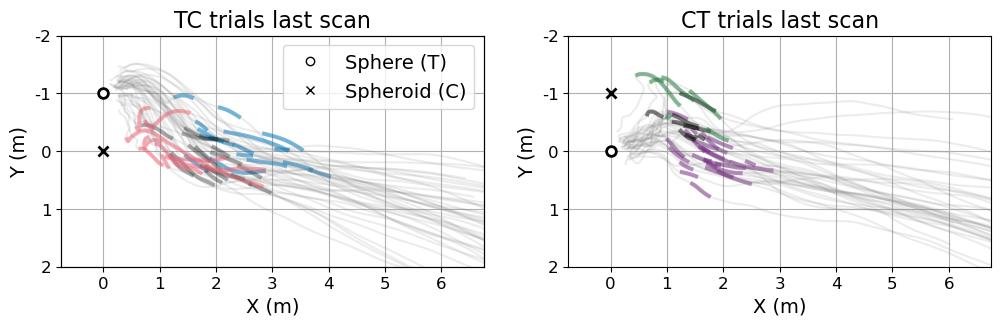

In [24]:
fig, ax_all = plt.subplots(1, 2, figsize=(12, 3), facecolor="w")

plt.subplots_adjust(hspace=0.4)



# ======================================
# TC trials last scan trajectories
# ======================================
ax_track_TC = ax_all[0]

for c_seq, c_name, c_color in zip(
    np.arange(len(color_cluster_7))[:3], list(color_cluster_7.keys())[:3], list(color_cluster_7.values())[:3]
):
    for df_track, df_track_ls in zip(df_track_all[c_seq], df_track_ls_all[c_seq]):
        ax_track_TC.plot(
            df_track[df_track["before_touch"]]["DTAG_X"],
            df_track[df_track["before_touch"]]["DTAG_Y"],
            color="grey", alpha=0.15
        )
        
        if c_seq == 1:  # moderate curve: lighter color
            ax_track_TC.plot(df_track_ls["DTAG_X"], df_track_ls["DTAG_Y"],
                color=c_color, lw=3, alpha=0.3
            )
        else:
            ax_track_TC.plot(df_track_ls["DTAG_X"], df_track_ls["DTAG_Y"],
                color=c_color, lw=3, alpha=0.5
            )
ax_track_TC.plot(0, 0, "kx", markeredgewidth=2, markersize=7, lw=1.5)
ax_track_TC.plot(0, -1, "ko", markeredgewidth=2, markersize=7, lw=1.5, markerfacecolor="w")
ax_track_TC.set_title("TC trials last scan", fontsize=16)


# ======================================
# CT trials last scan trajectories
# ======================================
ax_track_CT = ax_all[1]

for c_seq, c_name, c_color in zip(
    np.arange(len(color_cluster_7))[3:], list(color_cluster_7.keys())[3:], list(color_cluster_7.values())[3:]
):    
    for df_track, df_track_ls in zip(df_track_all[c_seq], df_track_ls_all[c_seq]):
        ax_track_CT.plot(
            df_track[df_track["before_touch"]]["DTAG_X"],
            df_track[df_track["before_touch"]]["DTAG_Y"],
            color="grey", alpha=0.15
        )
        
        if c_seq == 1:  # moderate curve: lighter color
            ax_track_CT.plot(df_track_ls["DTAG_X"], df_track_ls["DTAG_Y"],
                color=c_color, lw=3, alpha=0.3
            )
        else:
            ax_track_CT.plot(df_track_ls["DTAG_X"], df_track_ls["DTAG_Y"],
                color=c_color, lw=3, alpha=0.5
            )
ax_track_CT.plot(0, -1, "kx", markeredgewidth=2, markersize=7)
ax_track_CT.plot(0, 0, "ko", markeredgewidth=2, markersize=7, markerfacecolor="w")
ax_track_CT.set_title("CT trials last scan", fontsize=16)


# Add legend for targets
ax_track_mock = plt.axes(ax_track_TC.get_position())
ax_track_mock.patch.set_alpha(0)
ax_track_mock.plot(np.nan, np.nan, "ko", label="Sphere (T)", markerfacecolor="w")
ax_track_mock.plot(np.nan, np.nan, "kx", label="Spheroid (C)")
ax_track_mock.set_xticks([])
ax_track_mock.set_yticks([])
ax_track_mock.legend(fontsize=14, loc="upper right")


# Adjust xy-limit of trajetory panels
for axx in [ax_track_TC, ax_track_CT]:
    axx.set_xticks(np.arange(-1, 9))
    axx.set_xticklabels(np.arange(-1, 9), fontsize=12)
    axx.set_yticks(np.arange(-3, 4))
    axx.set_yticklabels(np.arange(-3, 4), fontsize=12)
    axx.set_ylim(2, -2)
    axx.set_xlim(-0.75, 6.75)
    axx.grid()
    axx.set_xlabel("X (m)", fontsize=14)
    axx.set_ylabel("Y (m)", fontsize=14)

## Functions to annotate p values

## Put everything together

In [25]:
scan_bins = np.arange(0, 27) - 0.5
scan_x = (scan_bins[:-1] + scan_bins[1:])/2
scan_bar_width = 0.25

# Vertical shift for CT clusters
vert_shift = 0.4

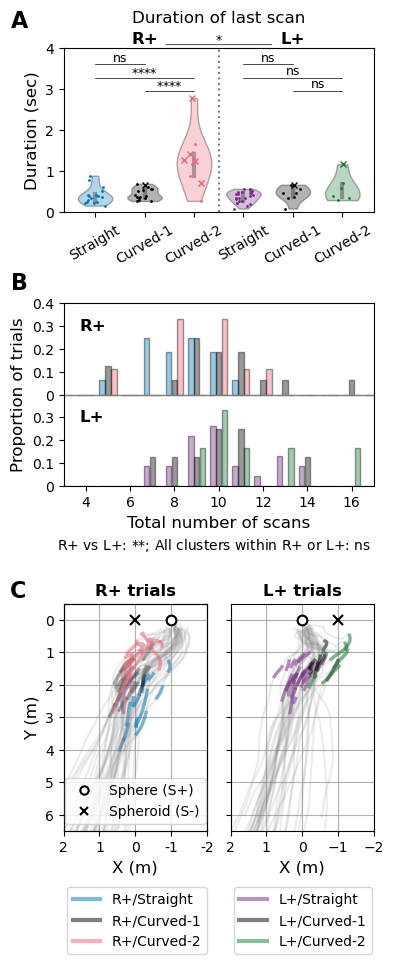

In [26]:
fig = plt.figure(figsize=(4, 9), facecolor="w")

gs = fig.add_gridspec(3, 2)

plt.subplots_adjust(hspace=0.4, wspace=0.1)


# ==================================================
# Duration of last scan: AR=1.3 cluster comparison
# ==================================================
ax_duration = fig.add_subplot(gs[0, :])

for seq in range(6):
    vals = df_cluster_clean_7[seq]["time_last_nonchosen"].values
    
    idx_cross = (
        df_cluster_clean_7[seq]["time_buzz_onset_clean"]
        < df_cluster_clean_7[seq]["time_decision"]
    )
    vals_dot = df_cluster_clean_7[seq]["time_last_nonchosen"][~idx_cross].values
    vals_cross = df_cluster_clean_7[seq]["time_last_nonchosen"][idx_cross].values
    
    utils_plot.plot_vio(
        ax_duration, vals, seq,
        widths=0.7, color=color_cluster_seq_7[seq], qbar_alpha=0.3
    )
    utils_plot.plot_jitter(
        ax_duration, seq, vals_dot, width=0.4,
        color=color_cluster_seq_7[seq], marker=".", markersize=2
    )
    utils_plot.plot_jitter(
        ax_duration, seq, vals_cross, width=0.4,
        color=color_cluster_seq_7[seq], marker="x", markersize=4
    )
ax_duration.set_title("Duration of last scan\n", fontsize=13)
ax_duration.set_ylabel("Duration (sec)", fontsize=12)
ax_duration.set_xticks(np.arange(6))
ax_duration.set_xticklabels(CLUSTER_STR_7, fontsize=10, rotation=30)
ax_duration.set_yticks(np.arange(0, 4.5, 1))
ax_duration.set_yticklabels(np.arange(0, 4.5, 1).astype(int), fontsize=10)
ax_duration.set_ylim(0, 4)
ax_duration.axvline(2.5, color="grey", ls=":")


# p value annotation
df_stat_position = pd.read_csv(stat_path / "AR13_last_scan_duration_position_contrast.csv")
df_stat_cluster = pd.read_csv(stat_path / "AR13_last_scan_duration_cluster_contrast.csv")
utils_plot.annotate_p_val_position(ax_duration, df_stat_position, fontsize=9)
utils_plot.annotate_p_val_cluster(
    ax_duration, df_stat_cluster, fontsize=9, ratio=True,
    vert_h=np.array([0.9 , 0.82, 0.74, 0.9 , 0.82, 0.74])
)

ylim = ax_duration.get_ylim()
ax_duration.text(1, ylim[1]*1.03, "R+", fontsize=12, ha="center", fontweight="bold")
ax_duration.text(4, ylim[1]*1.03, "L+", fontsize=12, ha="center", fontweight="bold")

# Adjust axis position
pos_duration = ax_duration.get_position()
ax_duration.set_position(
    [pos_duration.x0, pos_duration.y0+0.02, pos_duration.width, pos_duration.height-0.02]
)



# ==================================================
# Total number of scans
# ==================================================
ax_scan = fig.add_subplot(gs[1, :])

for seq in range(6):
    ta_cluster, _ = np.histogram(
        df_cluster_clean_7[seq]["scan_combined"]-1, bins=scan_bins, density=True
    )

    # Horiztonal bar shift
    if np.mod(seq, 3) == 0:
        shift = -scan_bar_width-0.01 # if straight shift bar leftward
    elif np.mod(seq, 3) == 1:
        shift = 0  # if curved 1 do not shift bar
    else:
        shift = scan_bar_width+0.01  # if curved 2 shift bar rightward
    
    bottom = vert_shift if seq <= 2 else 0

    ax_scan.bar(
        x=scan_x + shift, height=ta_cluster, width=scan_bar_width, bottom=bottom,
        alpha=0.4, edgecolor="k", color=color_cluster_seq_7[seq], label=CLUSTER_STR_7[seq],
    )
    
ax_scan.axhline(vert_shift, color="grey", lw=1)


# Axis labels
ax_scan.set_ylim(0, 0.8)
ax_scan.set_yticks(np.arange(0, 0.9, 0.1))
ax_scan.set_yticklabels([0, 0.1, 0.2, 0.3, 0, 0.1, 0.2, 0.3, 0.4], fontsize=10)

ax_scan.set_xticks(np.arange(0, 25, 2))
ax_scan.set_xticklabels(np.arange(0, 25, 2), fontsize=10)
ax_scan.set_xlim(3, 17)

ax_scan.set_title("Total number of scans", fontsize=13)

ax_scan.set_xlabel("Number of scans", fontsize=12)
ax_scan.set_ylabel("Proportion of trials", fontsize=12)


ax_scan.text(3.7, 0.7, "R+", fontsize=12, va="center", fontweight="bold")
ax_scan.text(3.7, 0.3, "L+", fontsize=12, va="center", fontweight="bold")



# Stats annotation
df_stat_position = pd.read_csv(stat_path / f"AR13_scan_combined_position_contrast.csv")
p_val_position = utils_plot.get_p_val_position(df_stat_position)
p_val_position = utils_plot.get_p_star(p_val_position)  # plot star only and no numbers
tcct_str = f"R+ v. L+: {p_val_position}"
ax_scan.text(
    2.7, -0.26, 
    f"R+ vs L+: {p_val_position}; All clusters within R+ or L+: ns",
    ha="left", va="center", fontsize=10, linespacing=1.4
)





# ===========================
# Last scan TC tracks
# ===========================
ax_track_TC = fig.add_subplot(gs[2, 0])

for c_seq, c_name, c_color in zip(
    np.arange(len(color_cluster_7))[:3], list(color_cluster_7.keys())[:3], list(color_cluster_7.values())[:3]
):
    for df_track, df_track_ls in zip(df_track_all[c_seq], df_track_ls_all[c_seq]):
        ax_track_TC.plot(
            df_track[df_track["before_touch"]]["DTAG_Y"],
            df_track[df_track["before_touch"]]["DTAG_X"],
            color="grey", alpha=0.15
        )
        
        if c_seq == 1:  # moderate curve: lighter color
            ax_track_TC.plot(df_track_ls["DTAG_Y"], df_track_ls["DTAG_X"],
                color=c_color, lw=2.5, alpha=0.3
            )
        else:
            ax_track_TC.plot(df_track_ls["DTAG_Y"], df_track_ls["DTAG_X"],
                color=c_color, lw=2.5, alpha=0.5
            )
ax_track_TC.plot(0, 0, "kx", markeredgewidth=1.5, markersize=7, lw=1.5)
ax_track_TC.plot(-1, 0, "ko", markeredgewidth=1.5, markersize=7, lw=1.5, markerfacecolor="w")
ax_track_TC.set_title("R+ trials", fontsize=12, fontweight="bold")



# ===========================
# Last scan CT tracks
# ===========================
ax_track_CT = fig.add_subplot(gs[2, 1])

for c_seq, c_name, c_color in zip(
    np.arange(len(color_cluster_7))[3:], list(color_cluster_7.keys())[3:], list(color_cluster_7.values())[3:]
):    
    for df_track, df_track_ls in zip(df_track_all[c_seq], df_track_ls_all[c_seq]):
        ax_track_CT.plot(
            df_track[df_track["before_touch"]]["DTAG_Y"],
            df_track[df_track["before_touch"]]["DTAG_X"],
            color="grey", alpha=0.15
        )
        
        if c_seq == 1:  # moderate curve: lighter color
            ax_track_CT.plot(df_track_ls["DTAG_Y"], df_track_ls["DTAG_X"],
                color=c_color, lw=2.5, alpha=0.3
            )
        else:
            ax_track_CT.plot(df_track_ls["DTAG_Y"], df_track_ls["DTAG_X"],
                color=c_color, lw=2.5, alpha=0.5
            )
ax_track_CT.plot(-1, 0, "kx", markeredgewidth=1.5, markersize=7)
ax_track_CT.plot(0, 0, "ko", markeredgewidth=1.5, markersize=7, markerfacecolor="w")
ax_track_CT.set_title("L+ trials", fontsize=12, fontweight="bold")


# Adjust track panel positions
pos_track_TC = ax_track_TC.get_position()
ax_track_TC.set_position(
    [pos_track_TC.x0, pos_track_TC.y0-0.1, #-0.065,
     pos_track_TC.width*0.97, pos_track_TC.height+0.05]
)
pos_track_CT = ax_track_CT.get_position()
ax_track_CT.set_position(
    [pos_track_CT.x0 + pos_track_CT.width*0.03, pos_track_CT.y0-0.1, #-0.065,
     pos_track_CT.width*0.97, pos_track_CT.height+0.05]
)


# Add legend for targets
ax_track_mock = plt.axes(ax_track_TC.get_position())
ax_track_mock.patch.set_alpha(0)
ax_track_mock.plot(np.nan, np.nan, "ko", label="Sphere (S+)", markerfacecolor="w", markeredgewidth=1.5)
ax_track_mock.plot(np.nan, np.nan, "kx", label="Spheroid (S-)", markeredgewidth=1.5)
ax_track_mock.set_xticks([])
ax_track_mock.set_yticks([])
ax_track_mock.legend(fontsize=10, loc="lower center")


# Adjust xy-limit of trajetory panels
for axx in [ax_track_TC, ax_track_CT]:
    axx.set_yticks(np.arange(-1, 9))
    axx.set_xticks(np.arange(-3, 4))
    axx.set_xlim(2, -2)
    axx.set_ylim(6.5, -0.5)
    axx.set_xlabel("X (m)", fontsize=12)
    axx.grid()
ax_track_TC.set_ylabel("Y (m)", fontsize=12)
ax_track_TC.set_xticklabels(np.arange(-3, 4), fontsize=10)
ax_track_TC.set_yticklabels(np.arange(-1, 9), fontsize=10)
ax_track_CT.set_yticklabels("")


# Add legend for cluster tracks
ax_track_TC.plot(np.nan, np.nan, color_cluster_7["TC_straight"], label="R+/Straight", alpha=0.5, lw=3)
ax_track_TC.plot(np.nan, np.nan, color_cluster_7["TC_curved1"], label="R+/Curved-1", alpha=0.5, lw=3)
ax_track_TC.plot(np.nan, np.nan, color_cluster_7["TC_curved2"], label="R+/Curved-2", alpha=0.5, lw=3)
ax_track_TC.legend(
    fontsize=10, loc="lower left",
    bbox_to_anchor=(2.1, 10.5), bbox_transform=ax_track_TC.transData
)

ax_track_CT.plot(np.nan, np.nan, color_cluster_7["CT_straight"], label="L+/Straight", alpha=0.5, lw=3)
ax_track_CT.plot(np.nan, np.nan, color_cluster_7["CT_curved1"], label="L+/Curved-1", alpha=0.5, lw=3)
ax_track_CT.plot(np.nan, np.nan, color_cluster_7["CT_curved2"], label="L+/Curved-2", alpha=0.5, lw=3)
ax_track_CT.legend(
    fontsize=10, loc="lower left",
    bbox_to_anchor=(2.1, 10.5), bbox_transform=ax_track_CT.transData
)


# Add panel labels
ax_duration.text(-1.7, 4.5, "A", fontsize=16, fontweight="bold")
ax_scan.text(0.6, 0.86, "B", fontsize=16, fontweight="bold")
ax_track_TC.text(3.5, -0.7, "C", fontsize=16, fontweight="bold")



plt.show()

fig.savefig(fig_path / "fig_scans_number_duration.png", dpi=300, bbox_inches="tight")
